In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from PIL import ImageFilter

class CenterErasing(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        y1 = (h - self.length) // 2
        y2 = (h + self.length) // 2
        x1 = (w - self.length) // 2
        x2 = (w + self.length) // 2

        img[:, y1:y2, x1:x2] = 0
        return img

def visualize(method=None):
    cifar100_classes = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
        'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
        'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
        'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
        'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
        'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
        'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
        'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
        'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
        'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
    ]
    labels_map = {i: cifar100_classes[i] for i in range(100)}

    _transforms = None
    if method is None:
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    elif method == 'crop':
        _transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    elif method == 'flip':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    elif method == 'color_jitter':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    elif method == 'grayscale':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    elif method == 'translation':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    elif method == 'shearing':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomAffine(degrees=0, shear=10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    elif method == 'rotation':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomRotation(degrees=180),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    elif method == 'cutout':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            CenterErasing(length=56),
        ])
    elif method == 'noise_injection':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Lambda(lambda img: img + 0.1 * torch.randn_like(img)),
        ])
    elif method == 'kernel_filtering':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(9, 11)),
        ])
    elif method == 'random_erasing':
        _transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
        ])

    # 데이터셋 로드
    train_dataset = datasets.CIFAR100(
        root="data",
        train=True,
        download=True,
        transform=_transforms
    )

    
    # 데이터 로더 생성
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

    # 데이터 로더에서 배치 하나 가져오기
    images, labels = next(iter(train_loader))

    # 이미지를 보여주기 위해 정규화를 되돌림
    def imshow(img):
        img = img / 2 + 0.5  # 정규화 되돌림
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    # 이미지와 레이블 출력
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for idx in range(4):
        img = images[idx] / 2 + 0.5  # 정규화 되돌림
        npimg = img.numpy()
        ax = axes[idx]
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(labels_map[labels[idx].item()])
        ax.axis('off')

    plt.show()

Files already downloaded and verified


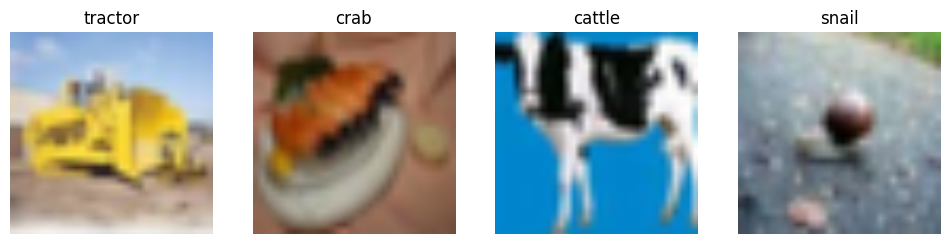

In [8]:
visualize()